## Summary

2 datasets were brought over from the EDA and the third dataset was generated by choosing 5 of the causal features from the second dataset. They were used to train a logistic regression and LGB decision trees models. Models were compared using the precision-recall curve in the region of interest (recall from 0.5 to 1.0). Other trade-off curves were also plotted for the best model.

## TOC

1. [Load libraries and helper functions](#Load-libraries-and-helper-functions)
2. [Load datasets and train](#Load-datasets-and-train)
3. [Best parameters and Model training curves](#Best-parameters-and-Model-training-curves)
4. [Precision-Recall trade-off curve](#Precision-Recall-trade-off-curve)
5. [ROI-Recall trade-off curve](#ROI-Recall-trade-off-curve)
6. [Profit-Recall trade-off curve](#Profit-Recall-trade-off-curve)
7. [Performance of the LGB model trained with the 31 features](#Performance-of-the-LGB-model-trained-with-the-31-features)

## Load libraries and helper functions
[Back to top](#TOC)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from lightgbm import LGBMClassifier as lgb
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# constants
LABEL = 'default.payment.next.month'
MERCHANT_FEE = 0.01
OVERDUE_INTEREST = 0.015
LOSS_GIVEN_DEFAULT = 0.011

In [2]:
# Helper functions
def splitXy_and_scale(ss, data):
    X, y = data.drop(columns=LABEL), data[LABEL]
    X = pd.DataFrame(ss.transform(X), index=X.index, columns=X.columns)
    return X, y

def split_and_scale_data(data, tst_ratio=.2, vld_ratio=.2):
    '''split and scale data to return training set (trn), validation set (vld), testing set (tst), 
    and combined set of training and validation data (t_v).
    '''
    
    N = data.shape[0]
    N_tst = int(tst_ratio*N)
    N_vld = int(vld_ratio*N)
    
    # shuffle
    raw = data.sample(frac=1., random_state=12)
    
    # split
    tst, t_v = np.split(raw, [N_tst], axis=0)
    vld, trn = np.split(t_v, [N_tst], axis=0)
    
    # scale and return
    ss = StandardScaler().fit(t_v.drop(columns=LABEL))
    return (
        splitXy_and_scale(ss, trn),
        splitXy_and_scale(ss, vld),
        splitXy_and_scale(ss, tst),
        splitXy_and_scale(ss, t_v),
    )

def divide(x, y, default=np.nan):
    '''return x/y or default when y=0'''
    return np.divide(x, y, out=np.full(len(y), default, dtype=np.float32), where=y!=0)

def cal_expected_roi_profit(y_pred, portfolio):
    '''Assuming the same portfolio for the predicting month as August,
    September's porfolio was used to calculate the expected ROI on November.
    
    If an user is predicted as default, the account is freezed, prohitbiting any transaction
    on November, and subsequently, no more additional transaction and late fee will be generated.
    However, 
    
    '''
    good = portfolio[~y_pred]
    
    # assuming all transaction domestic
    intl_trans_fee = 0
    merchant_fee = good[good[LABEL]==0]['aug_bill_trans'].sum() * MERCHANT_FEE
    overdue_interest = good[good[LABEL]==0]['aug_bill_overdue'].sum() * OVERDUE_INTEREST
    expected_default_loss = good[good[LABEL]==1]['aug_bill_overdue'].sum() * LOSS_GIVEN_DEFAULT
    
    expected_revenue = intl_trans_fee + merchant_fee + overdue_interest
    expected_cost = expected_default_loss
    
    expected_roi = np.nan if expected_cost==0 else expected_revenue/expected_cost
    expected_profit = expected_revenue - expected_cost
    
    expected_exposure = good[good[LABEL]==0]['aug_bill_trans'].sum()
    return expected_roi, expected_profit, expected_revenue, expected_cost, expected_exposure

def threshold_curve(y_true, y_pred_prob, portfolio):
    '''accept true labels and predicted probabilities and calculate scores of different thresholds'''
    
    thres = np.arange(0,1,0.01)
    
    # scores about correctness of labels
    results = np.array([confusion_matrix(y_true, y_pred_prob>t).ravel() for t in thres])
    tn, fp, fn, tp = list(map(np.array, zip(*results)))
    
    # roi score
    sub_portfolio = portfolio.loc[y_true.index]
    results = np.array([cal_expected_roi_profit(y_pred_prob>t, sub_portfolio) for t in thres])
    roi, profit, revenue, cost, exposure = list(map(np.array, zip(*results)))
    
    scores = dict(
        tn=tn, fp=fp, fn=fn, tp=tp,
        recall=divide(tp, tp+fn), tpr=divide(tp, tp+fn), 
        precision=divide(tp, tp+fp, 1), fpr=divide(fp, tn+fp),
        accuracy=divide(tp+tn, tp+tn+fp+fn), jaccard=divide(tn, tn+fp+fn),
        roi=roi, profit=profit, revenue=revenue, cost=cost, exposure=exposure
    )
    return pd.DataFrame(scores, index=thres)

def gen_log(t_v_y_true, t_v_y_pred_prob, tst_y_true, tst_y_pred_prob, portfolio, **kwargs):
    '''generate a standard dictionary log that includes additional kwargs'''
    
    return dict(
        kwargs, 
        trn_threshold_curve=threshold_curve(t_v_y_true, t_v_y_pred_prob, portfolio),
        tst_threshold_curve=threshold_curve(tst_y_true, tst_y_pred_prob, portfolio),
    )

def train_and_log_baseline_model(trn, vld, tst, t_v, portfolio, searched_params):
    '''Generate a random list of predictions'''
    
    t_v_y_true, tst_y_true = t_v[1], tst[1]
    
    np.random.seed(29)
    t_v_y_pred_proba = np.random.rand(len(t_v_y_true))
    tst_y_pred_proba = np.random.rand(len(tst_y_true))
    
    kwargs = dict()
    return gen_log(t_v_y_true, t_v_y_pred_proba, tst_y_true, tst_y_pred_proba, portfolio, **kwargs)

def train_and_log_logistic_regression(trn, vld, tst, t_v, portfolio, searched_params):
    '''CV Grid Search for logistic regression model'''
    
    fixed_params = dict(random_state=10, max_iter=10000, penalty='elasticnet', solver='saga')
    
    cv = GridSearchCV(
        LogisticRegression(**fixed_params), 
        cv=5, verbose=0, param_grid=searched_params
    ).fit(*t_v) 

    t_v_X, t_v_y_true = t_v
    tst_X, tst_y_true = tst
    
    t_v_y_pred_proba = cv.predict_proba(t_v_X)[:,1]
    tst_y_pred_proba = cv.predict_proba(tst_X)[:,1]
    
    kwargs = dict(
        cv=cv,
        model=cv.best_estimator_,
        param=cv.best_estimator_.get_params(),
        best_param=cv.best_params_,
    )
    return gen_log(t_v_y_true, t_v_y_pred_proba, tst_y_true, tst_y_pred_proba, portfolio, **kwargs)

def train_and_log_lgb_decision_trees(trn, vld, tst, t_v, portfolio, searched_params):
    '''CV Grid Search for LGB decision trees model'''
    
    fixed  = dict(
        max_depth=3, learning_rate=0.01,
        reg_lambda=30, reg_alpha=30, min_child_samples=500, 
        boosting_type='gbdt', metric='binary_logloss', saved_feature_importance_type=1, 
        verbose=-1, seed=133, n_estimators=1000,
    )

    cv = GridSearchCV(
        lgb(**fixed), cv=5, verbose=0, param_grid=searched_params
    ).fit(*trn, verbose=False, eval_set=[vld, trn], early_stopping_rounds=100)

    t_v_X, t_v_y_true = t_v
    tst_X, tst_y_true = tst
    
    t_v_y_pred_proba = cv.predict_proba(t_v_X)[:,1]
    tst_y_pred_proba = cv.predict_proba(tst_X)[:,1]
    
    kwargs = dict(
        cv=cv,
        model=cv.best_estimator_,
        param=cv.best_estimator_.get_params(),
        best_param=cv.best_params_,
    )
    return gen_log(t_v_y_true, t_v_y_pred_proba, tst_y_true, tst_y_pred_proba, portfolio, **kwargs)

# def train_and_log_neural_network(trn, vld, tst, t_v, portfolio, searched_params):
#     adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
#     init1 = tf.keras.initializers.GlorotUniform(seed=1)
#     init2 = tf.keras.initializers.GlorotUniform(seed=2)
#     init3 = tf.keras.initializers.GlorotUniform(seed=3)

#     t_v_X, t_v_y_true = t_v
#     tst_X, tst_y_true = tst
    
#     model = tf.keras.Sequential([
#         tf.keras.layers.InputLayer((t_v_X.shape[1],)),
#         tf.keras.layers.Dense(16, use_bias=False, kernel_initializer=init1, activation='relu'),
#         tf.keras.layers.Dropout(rate=0.3),
#         tf.keras.layers.Dense(8, use_bias=False, kernel_initializer=init2, activation='relu'),
#         tf.keras.layers.Dropout(rate=0.3),
#         tf.keras.layers.Dense(4, use_bias=False, kernel_initializer=init2, activation='relu'),
#         tf.keras.layers.Dropout(rate=0.3),
#         tf.keras.layers.Dense(1, use_bias=False, kernel_initializer=init3, activation='sigmoid'),
#     ])
#     model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

#     hist = model.fit(*trn, validation_data=vld, epochs=100, verbose=0, shuffle=True, batch_size=32)

    
#     t_v_y_pred_proba = model.predict(t_v_X).flatten()
#     tst_y_pred_proba = model.predict(tst_X).flatten()
    
#     kwargs = dict(model=model, hist=hist)
#     return gen_log(t_v_y_true, t_v_y_pred_proba, tst_y_true, tst_y_pred_proba, portfolio, **kwargs)

In [3]:
def training_wrapper(data, portfolio, searched_params_collection):
    logbook = {}

    # data splitting and scaling
    datasets = split_and_scale_data(data)

    # model training
    searched_params = searched_params_collection.get('random_baseline', dict())
    logbook['random_baseline'] = train_and_log_baseline_model(*datasets, portfolio, searched_params)

    searched_params = searched_params_collection.get('logistic_regression', dict())
    logbook['logistic_regression'] = train_and_log_logistic_regression(*datasets, portfolio, searched_params)

    searched_params = searched_params_collection.get('lgb_decision_trees', dict())
    logbook['lgb_decision_trees'] = train_and_log_lgb_decision_trees(*datasets, portfolio, searched_params)

    return logbook

## Load datasets and train
[Back to top](#TOC)

In [4]:
# read the 3 datasets as described in Intro
data1 = pd.read_csv('data_original_features.csv')
data2 = pd.read_csv('data_with_new_features.csv')
data3 = data2[['LIMIT_BAL', 'MARRIAGE', 'LONGEST_DELAY', 'NO_BAD_MONTHS', 'BAD_MONTH_PROXIMITY', LABEL]]

portfolio1 = pd.read_csv('data_original_features_portfolio.csv')
portfolio2 = pd.read_csv('data_with_new_features_portfolio.csv')
portfolio3 = portfolio2

In [5]:
%%time
searched_params_collection = {
    'logistic_regression': dict(
        C=np.linspace(.1, .7, 5), 
        l1_ratio=[0,.25,.5],
    ),
    'lgb_decision_trees': dict(
        subsample=[.8,.9], 
        num_leaves=[4, 8], 
        subsample_freq=[1, 3],
        colsample_bytree=[.4,.5], 
    ),
}
logbook1 = training_wrapper(data1, portfolio1, searched_params_collection)

CPU times: user 8min 49s, sys: 42.1 s, total: 9min 31s
Wall time: 2min 27s


In [6]:
%%time
searched_params_collection = {
    'logistic_regression': dict(
        C=np.linspace(.1, .7, 5),
        l1_ratio=[0,.25,.5],
    ),
    'lgb_decision_trees': dict(
        subsample=[.8,.9], 
        num_leaves=[4, 6], 
        subsample_freq=[5, 7],
        colsample_bytree=[.6,.8], 
    ),
}
logbook2 = training_wrapper(data2, portfolio2, searched_params_collection)

CPU times: user 11min 30s, sys: 42.7 s, total: 12min 13s
Wall time: 3min


In [7]:
%%time
searched_params_collection = {
    'logistic_regression': dict(
        C=np.linspace(.01, .07, 5),
        l1_ratio=[0,.25,.5],
    ),
    'lgb_decision_trees': dict(
        subsample=[.8,.9,], 
        num_leaves=[8, 12], 
        subsample_freq=[5, 7],
        colsample_bytree=[.8,.9], 
    ),
}
logbook3 = training_wrapper(data3, portfolio3, searched_params_collection)

CPU times: user 11min 3s, sys: 3.56 s, total: 11min 7s
Wall time: 1min 45s


In [8]:
names = ['25 raw features', '31 raw+engineered features', '5 casual features']
datas = [data1, data2, data3]
logbooks = [logbook1, logbook2, logbook3]
portfolios = [portfolio1, portfolio2, portfolio3]

lss = dict(zip(names, [':', '--', '-']))
colors = {'lgb_decision_trees':'blue', 'logistic_regression':'green', 'random_baseline':'red'}

## Best parameters and Model training curves

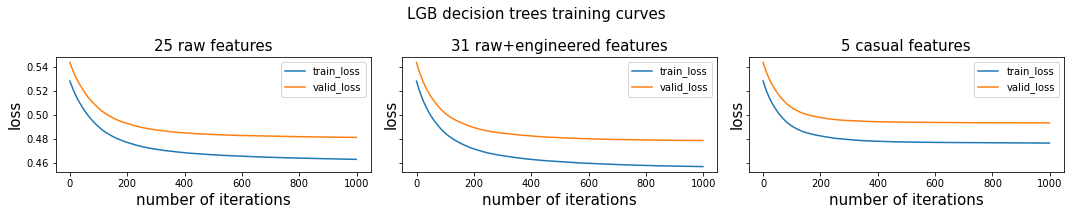

In [9]:
# # Print best parameters
# for name, logbook in zip(names, logbooks):
#     print('==>', name)
#     for model_name, logs in logbook.items():
#         if 'best_param' in logs:
#             print('*', model_name)
#             print(logs['best_param'])

# Model training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 3), sharey=True)
fig.suptitle('LGB decision trees training curves', fontsize=15)
for ax, name, logbook in zip(axes, names, logbooks):
    train_loss = logbook['lgb_decision_trees']['model'].evals_result_['training']['binary_logloss']
    valid_loss = logbook['lgb_decision_trees']['model'].evals_result_['valid_0']['binary_logloss']
    
    ax.plot(train_loss, label='train_loss')
    ax.plot(valid_loss, label='valid_loss')
    
    ax.set_xlabel('number of iterations',fontsize=15)
    ax.set_ylabel('loss',fontsize=15)
    ax.set_title(name, fontsize=15)
    ax.legend()
    
plt.tight_layout()
plt.show()

## Precision-Recall trade-off curve

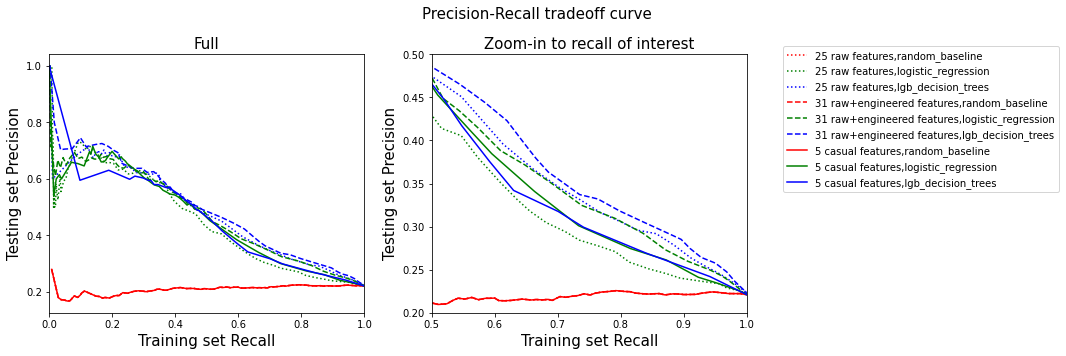

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Precision-Recall tradeoff curve', fontsize=15)
for name, logbook in zip(names, logbooks):
    for model_name, logs in logbook.items():
        curve = pd.concat([
            logs['trn_threshold_curve']['recall'],
            logs['tst_threshold_curve']['precision']
        ], axis=1).set_index('recall').sort_index()['precision']
        curve.plot(ls=lss[name], color=colors[model_name], ax=axes[0], label='%s,%s'%(name, model_name))
        curve.plot(ls=lss[name], color=colors[model_name], ax=axes[1], label='%s,%s'%(name, model_name))

for ax in axes:
    ax.set_xlabel('Training set Recall', fontsize=15)
    ax.set_ylabel('Testing set Precision',fontsize=15)

axes[0].set_title('Full', fontsize=15)
axes[1].set_title('Zoom-in to recall of interest', fontsize=15)
axes[0].set_xlim(0,1)
axes[1].set_xlim(.5,1)
axes[1].set_ylim(.2,.5)

plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.tight_layout()
plt.show()

## ROI-Recall trade-off curve

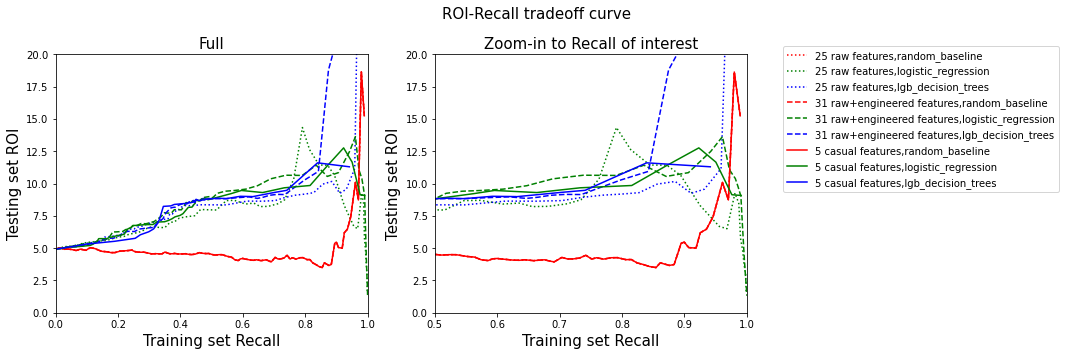

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('ROI-Recall tradeoff curve', fontsize=15)
for name, logbook in zip(names, logbooks):
    for model_name, logs in logbook.items():
        curve = pd.concat([
            logs['trn_threshold_curve']['recall'],
            logs['tst_threshold_curve']['roi']
        ], axis=1).set_index('recall').sort_index()['roi']
        curve.plot(ls=lss[name], color=colors[model_name], ax=axes[0], label='%s,%s'%(name, model_name))
        curve.plot(ls=lss[name], color=colors[model_name], ax=axes[1], label='%s,%s'%(name, model_name))

for ax in axes:
    ax.set_xlabel('Training set Recall', fontsize=15)
    ax.set_ylabel('Testing set ROI',fontsize=15)

axes[0].set_title('Full', fontsize=15)
axes[1].set_title('Zoom-in to Recall of interest', fontsize=15)
axes[0].set_xlim(0,1)
axes[1].set_xlim(.5,1)
axes[0].set_ylim(0,20)
axes[1].set_ylim(0,20)

plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.tight_layout()
plt.show()

## Profit-Recall trade-off curve

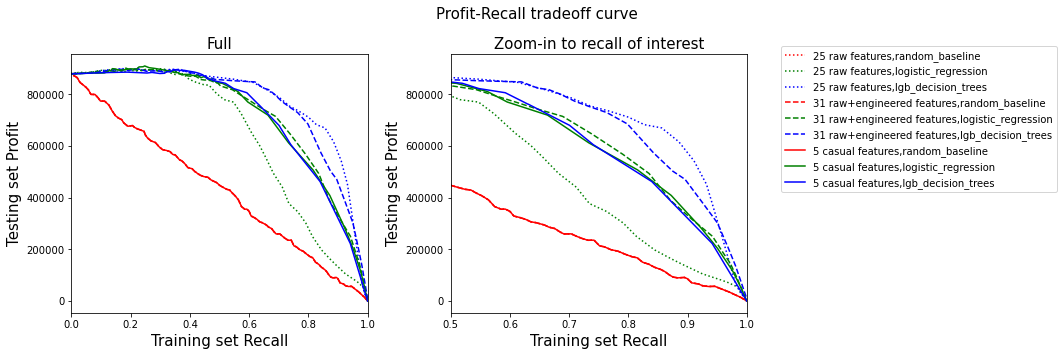

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Profit-Recall tradeoff curve', fontsize=15)
for name, logbook in zip(names, logbooks):
    for model_name, logs in logbook.items():
        curve = pd.concat([
            logs['trn_threshold_curve']['recall'],
            logs['tst_threshold_curve']['profit']
        ], axis=1).set_index('recall').sort_index()['profit']
        curve.plot(ls=lss[name], color=colors[model_name], ax=axes[0], label='%s,%s'%(name, model_name))
        curve.plot(ls=lss[name], color=colors[model_name], ax=axes[1], label='%s,%s'%(name, model_name))

for ax in axes:
    ax.set_xlabel('Training set Recall', fontsize=15)
    ax.set_ylabel('Testing set Profit', fontsize=15)

axes[0].set_title('Full', fontsize=15)
axes[1].set_title('Zoom-in to recall of interest', fontsize=15)
axes[0].set_xlim(0,1)
axes[1].set_xlim(.5,1)

plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.tight_layout()
plt.show()

## Performance of the LGB model trained with the 31 features

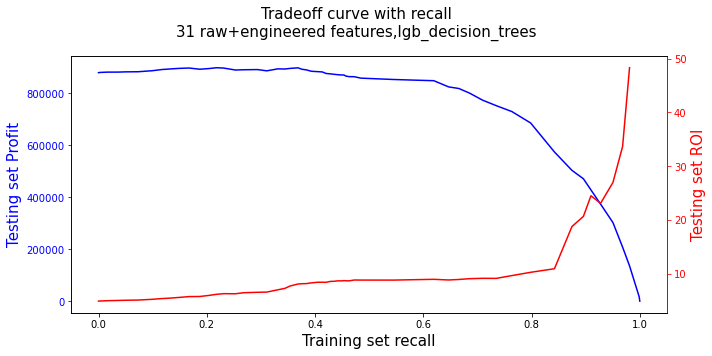

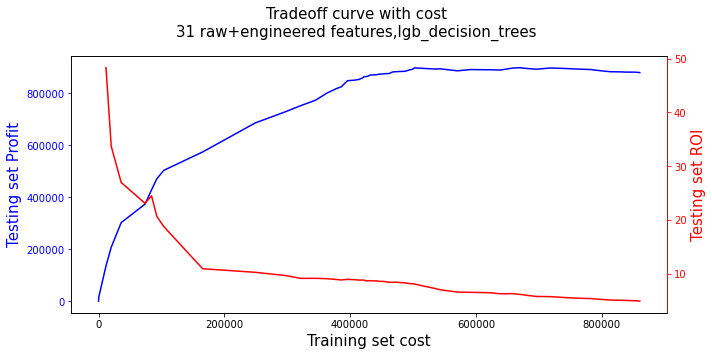

In [13]:
def model_performance(model_name, x_variable):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    fig.suptitle('Tradeoff curve with %s\n%s,%s'%(x_variable, names[1], model_name), fontsize=15)

    curve = pd.concat([
        logbooks[1][model_name]['trn_threshold_curve'][x_variable],
        logbooks[1][model_name]['tst_threshold_curve']['roi'],
        logbooks[1][model_name]['tst_threshold_curve']['profit'],
    ], axis=1).set_index(x_variable).sort_index()

    ax0p = ax
    ax0s = ax.twinx()

    curve['roi'].plot(ax=ax0s, label='ROI', color='red')
    curve['profit'].plot(ax=ax0p, label='Profit', color='blue')

    ax0s.set_ylabel('Testing set ROI', fontsize=15, color='red')
    ax0p.set_ylabel('Testing set Profit', fontsize=15, color='blue')

    ax0s.spines['right'].set_color('red')
    ax0p.spines['left'].set_color('blue')

    ax0s.tick_params(axis='y', colors='red')
    ax0p.tick_params(axis='y', colors='blue')

    ax0p.set_xlabel('Training set %s'%x_variable, fontsize=15)

    plt.tight_layout()
    plt.show()
    
model_performance(model_name='lgb_decision_trees', x_variable='recall')
model_performance(model_name='lgb_decision_trees', x_variable='cost')

In [14]:
# # Rank feature importance

# results = {'logistic_regression': [], 'lgb_decision_trees': []}
# for name, data, logbook in zip(names, datas, logbooks):
#     feature_names = data.drop(columns=LABEL).columns
#     for model_name, logs in logbook.items():
#         if model_name == 'lgb_decision_trees':
#             importance = logs['model'].feature_importances_
            
#         elif model_name == 'logistic_regression':
#             importance = logs['model'].coef_.flatten()
        
#         if model_name in results:
#             results[model_name].append(pd.Series(importance, index=feature_names, name=name))

# for model_name, result in results.items():
#     display(pd.concat(result, axis=1).sort_values('25 raw features', ascending=False))